Monolayer unit domain. Quadratic PML. Convergence

In [33]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


Domain, PML, refinement and physical configurations

In [34]:
# Define element size for the mesh refinement
h_i = [0.125,
    0.0625,
    0.0625 / 2,
    0.0625 / 4,]
    # 0.0625 / 8,]
    # 0.0625 / 16,
    # 0.0625 / 32]

# Domain configuration
Lx = 1. # fluid domain length (without PML)

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 1.  # m/s

# Define the density and velocity functions  
def rho_function(x):    
    return rho_media_1+x[0]*0
def vel_function(x):    
    return vel_media_1+x[0]*0

# PML configuration
pml_thickness = Lx/4
sigma_0 = 1.5*(4**3) #1.47 #0.484375

# Solver configuration

requested_eigenvalues_number = 100 # Number of eigenvalues to compute

Solver configuration and computing

In [35]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-2.5j)  
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [36]:
def get_approx_eigenpair(solver, selected_index, Q, V, dof, exact_value):
    from numpy import abs

    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore

    # Filtrar eigenvalores con parte real maior que 1e-12
    eigenvalues = []
    for i in range(solver.getConverged()):
        omega_value = solver.getEigenpair(i, vrA) * (1j)  # type: ignore
        if omega_value.real > 1e-12:
            eigenvalues.append((omega_value, vrA.copy()))

    if not (0 <= selected_index < len(eigenvalues)):
        raise IndexError("selected_index fóra de rango dos eigenvalores filtrados")

    # Comprobación do máis próximo ao exacto nun rango de ±5
    i_min = max(0, selected_index - 5)
    i_max = min(len(eigenvalues), selected_index + 6)

    closest_idx = min(
        range(i_min, i_max),
        key=lambda i: abs(eigenvalues[i][0] - exact_value)
    )

    if closest_idx != selected_index:
        print(f"Aviso: o índice {selected_index} non é o máis próximo ao valor exacto.")
        print(f"O máis próximo é o índice {closest_idx} con valor {eigenvalues[closest_idx][0]}")
    # else:
        # print("O índice seleccionado é o máis próximo ao valor exacto.")

    # Seleccionar o autovalor e vector correspondente
    omega_value, vrA = eigenvalues[closest_idx]

    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] /= p_h.eval([Lx, 0.0, 0.0], 1)  # normalizar
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] /= v_h.eval([Lx, 0.0, 0.0], 1)  # normalizar

    return [omega_value, p_h, v_h]


In [37]:
sigma_absorption=((Lx+pml_thickness)**3/3-Lx*(Lx+pml_thickness)**2+Lx**2*(Lx+pml_thickness)-1/3)*sigma_0
get_exact_pml_eigenvalue=lambda n: ((n+1) * np.pi * vel_media_1 - 1j *sigma_absorption) / (Lx + pml_thickness)

exact = [None] * 5 
for j in np.arange(0, 5,1):
    exact[j] = get_exact_pml_eigenvalue(j)


quadratic

In [38]:
# Define quadratic sigma function
sigma_x_quadratic_ufl=lambda x: conditional(x[0] > Lx, sigma_0*(x[0]-Lx)**2, 0.0)
# Initialize lists to store the approximated eigenpairs
approx_quadratic_P1_P0 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_quadratic_P2_P1 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_quadratic_P3_P2 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_quadratic_P4_P3 = [[0 for _ in range(5)] for _ in range(len(h_i))]

for i,h in enumerate(h_i):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h), [0, Lx + pml_thickness])
    # Define solver for quadratic PML
    [solver_quadratic_P1_P0, mesh, Q_P1_P0, V_P1_P0, dof_P1_P0]=get_configured_problem(mesh, [1,0], sigma_x_quadratic_ufl)
    [solver_quadratic_P2_P1, mesh, Q_P2_P1, V_P2_P1, dof_P2_P1]=get_configured_problem(mesh, [2,1], sigma_x_quadratic_ufl)
    [solver_quadratic_P3_P2, mesh, Q_P3_P2, V_P3_P2, dof_P3_P2]=get_configured_problem(mesh, [3,2], sigma_x_quadratic_ufl)
    [solver_quadratic_P4_P3, mesh, Q_P4_P3, V_P4_P3, dof_P4_P3]=get_configured_problem(mesh, [4,3], sigma_x_quadratic_ufl)

    for j in np.arange(0, 5,1):
        # Get the approximated eigenpair
        approx_quadratic_P1_P0[i][j] = get_approx_eigenpair(solver_quadratic_P1_P0, j, Q_P1_P0, V_P1_P0, dof_P1_P0, exact[j])[0]
        approx_quadratic_P2_P1[i][j] = get_approx_eigenpair(solver_quadratic_P2_P1, j, Q_P2_P1, V_P2_P1, dof_P2_P1, exact[j])[0]
        approx_quadratic_P3_P2[i][j] = get_approx_eigenpair(solver_quadratic_P3_P2, j, Q_P3_P2, V_P3_P2, dof_P3_P2, exact[j])[0]
        approx_quadratic_P4_P3[i][j] = get_approx_eigenpair(solver_quadratic_P4_P3, j, Q_P4_P3, V_P4_P3, dof_P4_P3, exact[j])[0]

# Ordenar cada fila de la lista
for i in range(len(approx_quadratic_P1_P0)):
    approx_quadratic_P1_P0[i] = sorted(approx_quadratic_P1_P0[i], key=lambda x: x.real)
    approx_quadratic_P2_P1[i] = sorted(approx_quadratic_P2_P1[i], key=lambda x: x.real)
    approx_quadratic_P3_P2[i] = sorted(approx_quadratic_P3_P2[i], key=lambda x: x.real)
    approx_quadratic_P4_P3[i] = sorted(approx_quadratic_P4_P3[i], key=lambda x: x.real)


In [39]:
def agrupar_por_posicion(lista_de_listas):
    return [list(grupo) for grupo in zip(*lista_de_listas)]

def borrar_filas_incompletas(lista_de_listas, longitud_minima):
    return [fila for fila in lista_de_listas if len(fila) >= longitud_minima]

# Uso de la función
longitud_minima = len(h_i)
groups_P1_P0=agrupar_por_posicion(approx_quadratic_P1_P0)
groups_P2_P1=agrupar_por_posicion(approx_quadratic_P2_P1)
groups_P3_P2=agrupar_por_posicion(approx_quadratic_P3_P2)
groups_P4_P3=agrupar_por_posicion(approx_quadratic_P4_P3)

groups_P1_P0 = borrar_filas_incompletas(groups_P1_P0, longitud_minima)
groups_P2_P1 = borrar_filas_incompletas(groups_P2_P1, longitud_minima)
groups_P3_P2 = borrar_filas_incompletas(groups_P3_P2, longitud_minima)
groups_P4_P3 = borrar_filas_incompletas(groups_P4_P3, longitud_minima)

In [40]:
rel_error_eig_0_P1_P0=abs((groups_P1_P0[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P1_P0=abs((groups_P1_P0[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P1_P0=abs((groups_P1_P0[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P1_P0=abs((groups_P1_P0[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P2_P1=abs((groups_P2_P1[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P2_P1=abs((groups_P2_P1[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P2_P1=abs((groups_P2_P1[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P2_P1=abs((groups_P2_P1[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P3_P2=abs((groups_P3_P2[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P3_P2=abs((groups_P3_P2[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P3_P2=abs((groups_P3_P2[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P3_P2=abs((groups_P3_P2[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P4_P2=abs((groups_P4_P3[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P4_P2=abs((groups_P4_P3[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P4_P2=abs((groups_P4_P3[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P4_P2=abs((groups_P4_P3[3] - exact[3])) / np.abs(exact[3]) 

In [41]:
print("P1-P0:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado (h_max):  {groups_P1_P0[idx][-4]}")
    print(f"  Aproximado        :  {groups_P1_P0[idx][-3]}")
    print(f"  Aproximado        :  {groups_P1_P0[idx][-2]}")
    print(f"  Aproximado (h_min):  {groups_P1_P0[idx][-1]}")
    error = abs(groups_P1_P0[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P1-P0:
Autovalor 0:
  Exacto:      (2.5132741228718345-0.3999999999999986j)
  Aproximado (h_max):  (2.5115253882522426-0.40085228920535126j)
  Aproximado        :  (2.5128323125896403-0.40043267971655094j)
  Aproximado        :  (2.5131651277981906-0.4001223397900563j)
  Aproximado (h_min):  (2.513247022594851-0.400031463643264j)
  Error rel.:  1.6317193806850244e-05

Autovalor 1:
  Exacto:      (5.026548245743669-0.3999999999999986j)
  Aproximado (h_max):  (5.090730774308722-0.3904131432739233j)
  Aproximado        :  (5.042348367504954-0.39812506326925245j)
  Aproximado        :  (5.030480945926225-0.3995687598943711j)
  Aproximado (h_min):  (5.027530382661389-0.3998946303297304j)
  Error rel.:  0.00019589194268110466

Autovalor 2:
  Exacto:      (7.5398223686155035-0.3999999999999986j)
  Aproximado (h_max):  (7.799731334966956-0.3823678721403531j)
  Aproximado        :  (7.60419301044762-0.39639602821588427j)
  Aproximado        :  (7.555847062990326-0.39915980096562237j)
  Aproxima

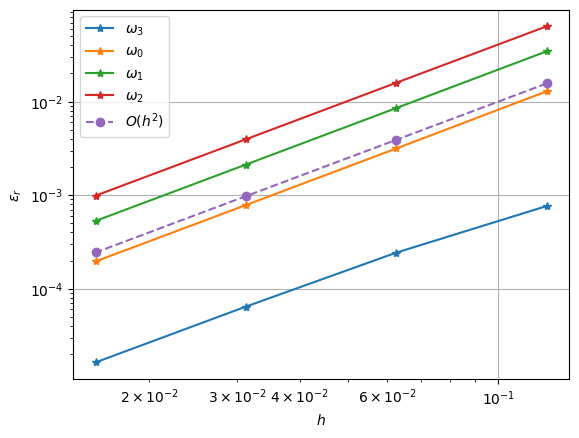

In [42]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P1_P0, "*-", label='$\omega_3$')
plt.plot(h_i, rel_error_eig_1_P1_P0, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_2_P1_P0, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_3_P1_P0, "*-", label='$\omega_2$')
plt.plot(
    h_i,
    [x**2 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{2}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
# plt.title(f"[P{problem.FE['p']._degree}-P{problem.FE['v']._degree}] - PML eigenvalues' convergence. {pml_type} profile.")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()

In [43]:
print("P2-P1:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P2_P1[idx][-1]}")
    error = abs(groups_P2_P1[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P2-P1:
Autovalor 0:
  Exacto:      (2.5132741228718345-0.3999999999999986j)
  Aproximado:  (2.513274145119302-0.40000005002728245j)
  Error rel.:  2.1513982135620785e-08

Autovalor 1:
  Exacto:      (5.026548245743669-0.3999999999999986j)
  Aproximado:  (5.026548373155399-0.40000019586732916j)
  Error rel.:  4.633901440945494e-08

Autovalor 2:
  Exacto:      (7.5398223686155035-0.3999999999999986j)
  Aproximado:  (7.539823259093892-0.4000004451315436j)
  Error rel.:  1.3185177460536847e-07

Autovalor 3:
  Exacto:      (10.053096491487338-0.3999999999999986j)
  Aproximado:  (10.05310036527482-0.4000008024913283j)
  Error rel.:  3.932030645388277e-07

Autovalor 4:
  Exacto:      (12.566370614359172-0.3999999999999986j)
  Aproximado:  (12.566382737211574-0.40000127013389036j)
  Error rel.:  9.694953211334e-07



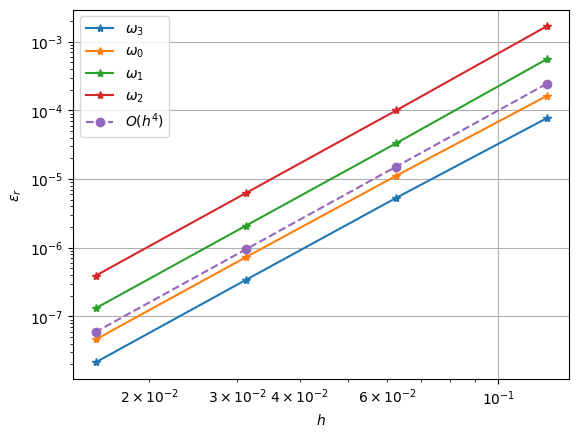

In [44]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P2_P1, "*-", label='$\omega_3$')
plt.plot(h_i, rel_error_eig_1_P2_P1, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_2_P2_P1, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_3_P2_P1, "*-", label='$\omega_2$')
plt.plot(
    h_i,
    [x**4 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{4}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()


In [45]:
print("P3-P2:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P3_P2[idx][-1]}")
    error = abs(groups_P3_P2[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P3-P2:
Autovalor 0:
  Exacto:      (2.5132741228718345-0.3999999999999986j)
  Aproximado:  (2.5132741229025544-0.4000000000027255j)
  Error rel.:  1.2118586893663282e-11

Autovalor 1:
  Exacto:      (5.026548245743669-0.3999999999999986j)
  Aproximado:  (5.026548245774461-0.40000000008387243j)
  Error rel.:  1.771911674061917e-11

Autovalor 2:
  Exacto:      (7.5398223686155035-0.3999999999999986j)
  Aproximado:  (7.539822368637809-0.40000000026135446j)
  Error rel.:  3.474056083371308e-11

Autovalor 3:
  Exacto:      (10.053096491487338-0.3999999999999986j)
  Aproximado:  (10.053096491840062-0.4000000005846625j)
  Error rel.:  6.786788089446214e-11

Autovalor 4:
  Exacto:      (12.566370614359172-0.3999999999999986j)
  Aproximado:  (12.566370616824758-0.4000000010743605j)
  Error rel.:  2.13914572145797e-10



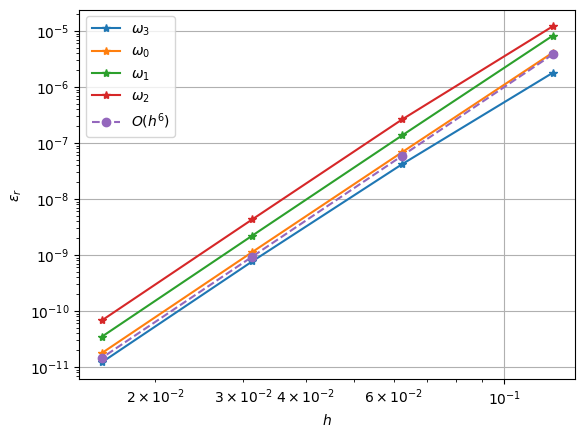

In [46]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P3_P2, "*-", label='$\omega_3$')
plt.plot(h_i, rel_error_eig_1_P3_P2, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_2_P3_P2, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_3_P3_P2, "*-", label='$\omega_2$')
plt.plot(
    h_i,
    [x**6 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{6}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()

In [47]:
print("P4-P3:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P4_P3[idx][-1]}")
    error = abs(groups_P4_P3[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P4-P3:
Autovalor 0:
  Exacto:      (2.5132741228718345-0.3999999999999986j)
  Aproximado:  (2.5132741228684328-0.4000000000001872j)
  Error rel.:  1.3387327393106806e-12

Autovalor 1:
  Exacto:      (5.026548245743669-0.3999999999999986j)
  Aproximado:  (5.02654824574082-0.39999999999978675j)
  Error rel.:  5.666186631816157e-13

Autovalor 2:
  Exacto:      (7.5398223686155035-0.3999999999999986j)
  Aproximado:  (7.539822368613069-0.39999999999993996j)
  Error rel.:  3.2252523729205845e-13

Autovalor 3:
  Exacto:      (10.053096491487338-0.3999999999999986j)
  Aproximado:  (10.053096491484855-0.40000000000020025j)
  Error rel.:  2.4764035585911005e-13

Autovalor 4:
  Exacto:      (12.566370614359172-0.3999999999999986j)
  Aproximado:  (12.566370614356963-0.4000000000004658j)
  Error rel.:  1.7964620297093342e-13



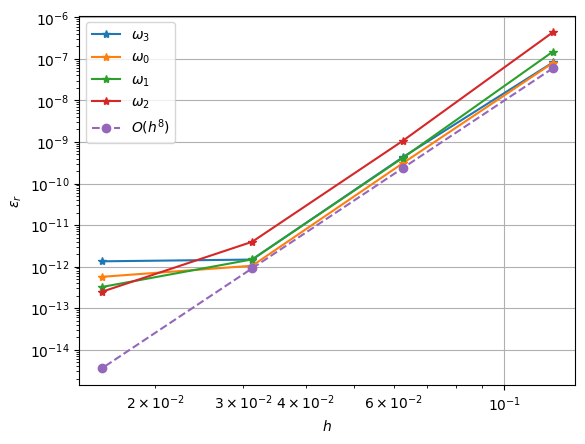

In [48]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P4_P2, "*-", label='$\omega_3$')
plt.plot(h_i, rel_error_eig_1_P4_P2, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_2_P4_P2, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_3_P4_P2, "*-", label='$\omega_2$')
plt.plot(
    h_i,
    [x**8 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{8}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()